<a href="https://colab.research.google.com/github/Oliwash254/machine-learning/blob/main/personality_trait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle \
    google-ml-edu==0.1.2 \
    keras~=3.8.0 \
    matplotlib~=3.10.0 \
    numpy~=2.0.0 \
    pandas~=2.2.0 \
    tensorflow~=2.18.0

# Upload your Kaggle API key (download it from Kaggle > Account > Create New API Token)
from google.colab import files
files.upload()  # Upload kaggle.json

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d rakeshkapilavai/extrovert-vs-introvert-behavior-data
!unzip extrovert-vs-introvert-behavior-data.zip

# Load the data
import pandas as pd
df = pd.read_csv("personality_dataset.csv")
df.head()

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data
License(s): CC-BY-SA-4.0
  0% 0.00/15.0k [00:00<?, ?B/s]
100% 15.0k/15.0k [00:00<00:00, 59.3MB/s]
Archive:  extrovert-vs-introvert-behavior-data.zip
  inflating: personality_dataset.csv  


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [11]:
import io
import keras
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import ml_edu.experiment
import ml_edu.results
import numpy as np
import pandas as pd
import plotly.express as px

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Ran the import statements.


##read and provide statistics on the dataset

In [12]:
df = pd.read_csv("personality_dataset.csv")
df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2837.0,2838.0,2834.0,2823.0,2835.0
mean,4.5,4.0,3.0,6.3,3.6
std,3.5,2.9,2.2,4.3,2.9
min,0.0,0.0,0.0,0.0,0.0
25%,2.0,2.0,1.0,3.0,1.0
50%,4.0,3.0,3.0,5.0,3.0
75%,8.0,6.0,5.0,10.0,6.0
max,11.0,10.0,7.0,15.0,10.0


#explore data

#identify the missing values


In [16]:
df.isnull().sum()

,0
Time_spent_Alone,63
Stage_fear,73
Social_event_attendance,62
Going_outside,66
Drained_after_socializing,52
Friends_circle_size,77
Post_frequency,65
Personality,0


In [17]:
df_cleaned = df.dropna()
df_cleaned.isnull().sum()

,0
Time_spent_Alone,0
Stage_fear,0
Social_event_attendance,0
Going_outside,0
Drained_after_socializing,0
Friends_circle_size,0
Post_frequency,0
Personality,0


In [18]:
for x_axis_data, y_axis_data in [('Time_spent_Alone', 'Social_event_attendance'), ('Going_outside', 'Friends_circle_size'), ('Time_spent_Alone', 'Friends_circle_size')]:
   px.scatter(df, x=x_axis_data, y=y_axis_data, color='Personality').show()

#visualize samples in 3D

In [19]:
x_axis_data = 'Time_spent_Alone'
y_axis_data = 'Going_outside'
z_axis_data = 'Friends_circle_size'

px.scatter_3d(df, x=x_axis_data, y=y_axis_data, z=z_axis_data, color='Personality').show()

In [20]:
#more example in 3D pictures
px.scatter_3d(df, x='Time_spent_Alone', y='Going_outside', z='Social_event_attendance', color='Personality').show()

#normalize data
achieved using z_score

In [26]:
# calcu;ate the z _score of each numerical column in the raw data and write
#them into  a new dataframe named df_norm

# Drop rows with missing values before normalization
df_cleaned = df.dropna()

feature_mean = df_cleaned.mean(numeric_only= True)
feature_std = df_cleaned.std(numeric_only=True)
numerical_features = df_cleaned.select_dtypes('number').columns
df_norm = (df_cleaned[numerical_features] - feature_mean) / feature_std

#copy personality to the new dataframe
df_norm['Personality'] = df_cleaned['Personality']
df_norm.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Personality
0,-0.1,0.0,1.3,1.6,0.5,Extrovert
1,1.3,-1.4,-1.3,-1.4,-0.2,Introvert
2,1.3,-1.0,-0.4,-0.3,-0.5,Introvert
3,-1.3,0.7,1.8,1.8,1.5,Extrovert
4,-0.4,1.7,0.4,0.4,0.5,Extrovert


#set the random seeds

In [27]:
keras.utils.set_random_seed(42)
np.random.seed(42)

#label and spit data

In [28]:
#create a column setting the extrovert label to 1 and the introvert label to 0
#then show 10 randomly selected rows.
df_norm['Class_Bool'] = (df_norm['Personality'] == 'Extrovert').astype('int')
df_norm.sample(10)


,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Personality,Class_Bool
1992,1.9,-1.4,-0.4,-0.5,-0.5,Introvert,0
286,0.4,-0.7,-1.3,-1.0,-0.9,Introvert,0
2396,-1.3,1.1,-0.0,-0.3,0.8,Extrovert,1
1102,-0.7,0.4,0.9,1.8,1.9,Extrovert,1
60,-1.0,1.7,0.9,0.6,2.2,Extrovert,1
2833,1.9,-1.4,-1.3,-0.8,-0.5,Extrovert,1
2411,-0.4,1.7,1.3,1.6,1.5,Extrovert,1
1231,0.1,-1.4,-0.4,-0.8,-0.9,Introvert,0
1028,0.7,-0.3,-0.9,-1.2,-0.9,Introvert,0
1200,1.9,-1.0,-0.4,-0.5,-0.5,Introvert,0


randomize and partition the dataset into train ,test , and validation splits, consisting of 80%, 10% and 10% of the dataset respectively

In [29]:
#create indices at the 80th and 90th percentiles
number_samples = len(df_norm)
index_80th = round(number_samples * 0.8)
index_90th = index_80th + round(number_samples * 0.1)
 #randomize order and split into train,validation,  and test with a .8, .1, .1 split
shuffled_df = df_norm.sample(frac=1, random_state=100)
train_data = shuffled_df.iloc[:index_80th]
validation_data = shuffled_df.iloc[index_80th:index_90th]
test_data = shuffled_df.iloc[index_90th:]
#show the first five rows of the  last split
test_data.head()


,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Personality,Class_Bool
12,-0.4,0.7,1.8,1.8,2.2,Extrovert,1
1266,1.3,-0.3,-1.3,-0.8,-0.9,Introvert,0
732,-0.7,1.7,1.3,0.9,1.9,Extrovert,1
866,0.1,-0.3,-0.4,-1.2,-1.2,Introvert,0
2443,-1.3,0.7,0.9,-0.3,0.5,Extrovert,1


It's important to prevent the model from getting the label as input during training, which is called label leakage. This can be done by storing features and labels as separate variables.

In [31]:
label_columns = ['Personality', 'Class_Bool']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()

#train the model


In [32]:
#name the feature we will train our model on
input_features = ['Time_spent_Alone','Social_event_attendance', 'Going_outside']

#define function that create and train model

In [45]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import ml_edu

# @title Define the function that create aand train a model.
def create_model(
    settings: ml_edu.experiment.ExperimentSettings,
    metrics: list[keras.metrics.Metric]

) -> keras.Model:
  """create and compile a simple classification model."""
  model_inputs = [tf.keras.Input(name=feature, shape=(1,))
  for feature in settings.input_features]
  # Use a Concatenate layer to assemble the different inputs into a single
  # tensor which will be given as input to the Dense layer.
  # For example: [input_1[0][0], input_2[0][0]]
  concatenated_inputs = keras.layers.concatenate(model_inputs)
  model_outputs = keras.layers.Dense(units=1, name='dense_layer', activation=keras.activations.sigmoid)(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_outputs)
  # Call the compile method to transform the layers into a model that
# Keras can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(
      optimizer=keras.optimizers.RMSprop(settings.learning_rate),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics
  )
  return model
def train_model(
    experiment_name: str,
    model: keras.Model,
    train_features: pd.DataFrame,
    train_labels: np.ndarray,
    settings: ml_edu.experiment.ExperimentSettings,) -> ml_edu.experiment.Experiment:
    """feed a dataset into the model in order to train it."""
    #the x parameter of keras.model.fit can be a list of arrays , where
    #each array contains the adata for one feature.
    features = {
        feature_name: np.array(train_features[feature_name])
        for feature_name in settings.input_features
    }
    history = model.fit(
        x=features,
        y=train_labels,
        batch_size=settings.batch_size,
        epochs=settings.number_epochs,
        verbose=0,

    )
    return ml_edu.experiment.Experiment(
        name=experiment_name,
        settings=settings,
        model=model,
        epochs=history.epoch,
        metrics_history=pd.DataFrame(history.history),
    )

print('Defined the create_model and train_model functions')

Defined the create_model and train_model functions


#define function that build and train a model

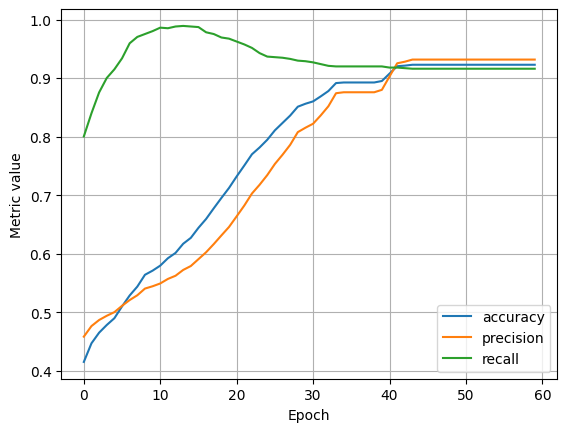

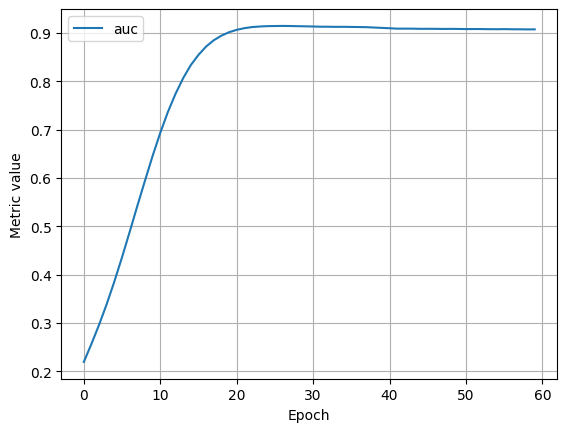

In [47]:
#lets define our first experiment settings
settings= ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision',thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall',thresholds=settings.classification_threshold
    ),
    tf.keras.metrics.AUC(name='auc')
]
#establish the model topography.
model = create_model(settings,metrics)
#train the model on the trainingset
experiment = train_model(
    'baseline',model,train_features,train_labels,settings
)
#plot metrics vs.epochs
ml_edu.results.plot_experiment_metrics(experiment,['accuracy','precision', 'recall'])
ml_edu.results.plot_experiment_metrics(experiment, ['auc'])

evaluate the model against the test set

In [49]:
def compare_train_test(experiment: ml_edu.experiment.Experiment, test_metrics: dict[str, float]):
                       print('comparing metrics between train and test:')
                       for metrics,test_value in test_metrics.items():
                        print('----')
                        print(f'Train {metrics}: {experiment.metrics_history[metrics].iloc[-1]:.4f}')
                        print(f'Test {metrics}: {test_value:.3f}')
#evaluate test metrics
test_metrics = experiment.evaluate(test_features,test_labels)
compare_train_test(experiment,test_metrics)

comparing metrics between train and test:
----
Train accuracy: 0.9228
Test accuracy: 0.935
----
Train auc: 0.9074
Test auc: 0.921
----
Train loss: 0.3229
Test loss: 0.290
----
Train precision: 0.9317
Test precision: 0.950
----
Train recall: 0.9160
Test recall: 0.920


#train the full_feature model and calculate the metrics

In [50]:
#specify all features
all_input_features = ['Time_spent_Alone','Social_event_attendance', 'Going_outside', 'Friends_circle_size']

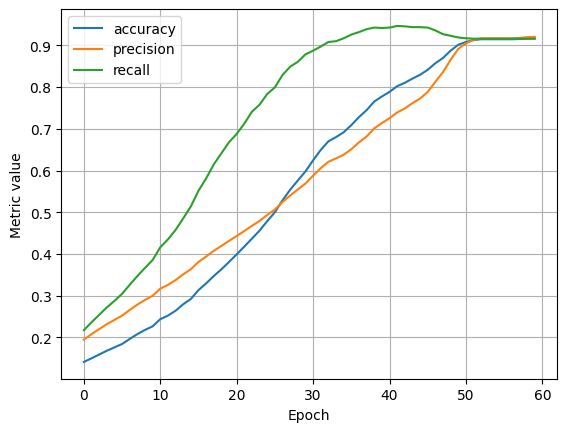

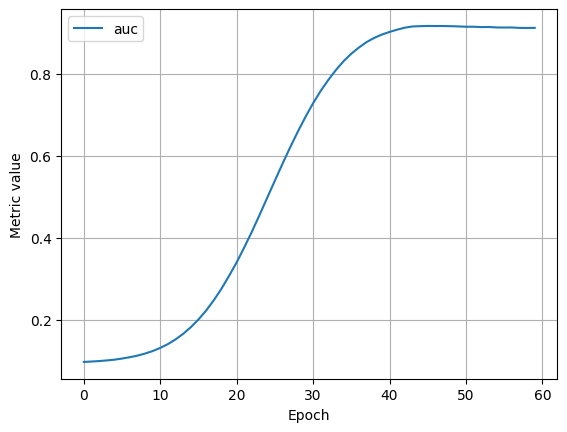

In [52]:
settings_all_features = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=all_input_features,
)
# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings_all_features.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings_all_features.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model_all_features = create_model(settings_all_features, metrics)

# Train the model on the training set.
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)

# Plot metrics vs. epochs
ml_edu.results.plot_experiment_metrics(
    experiment_all_features, ['accuracy', 'precision', 'recall']
)
ml_edu.results.plot_experiment_metrics(experiment_all_features, ['auc'])

#evaluate full-feature model on test split

In [53]:
test_metrics_all_features = experiment_all_features.evaluate(test_features, test_labels)
compare_train_test(experiment_all_features, test_metrics_all_features)


comparing metrics between train and test:
----
Train accuracy: 0.9168
Test accuracy: 0.927
----
Train auc: 0.9117
Test auc: 0.921
----
Train loss: 0.3316
Test loss: 0.309
----
Train precision: 0.9206
Test precision: 0.935
----
Train recall: 0.9160
Test recall: 0.920


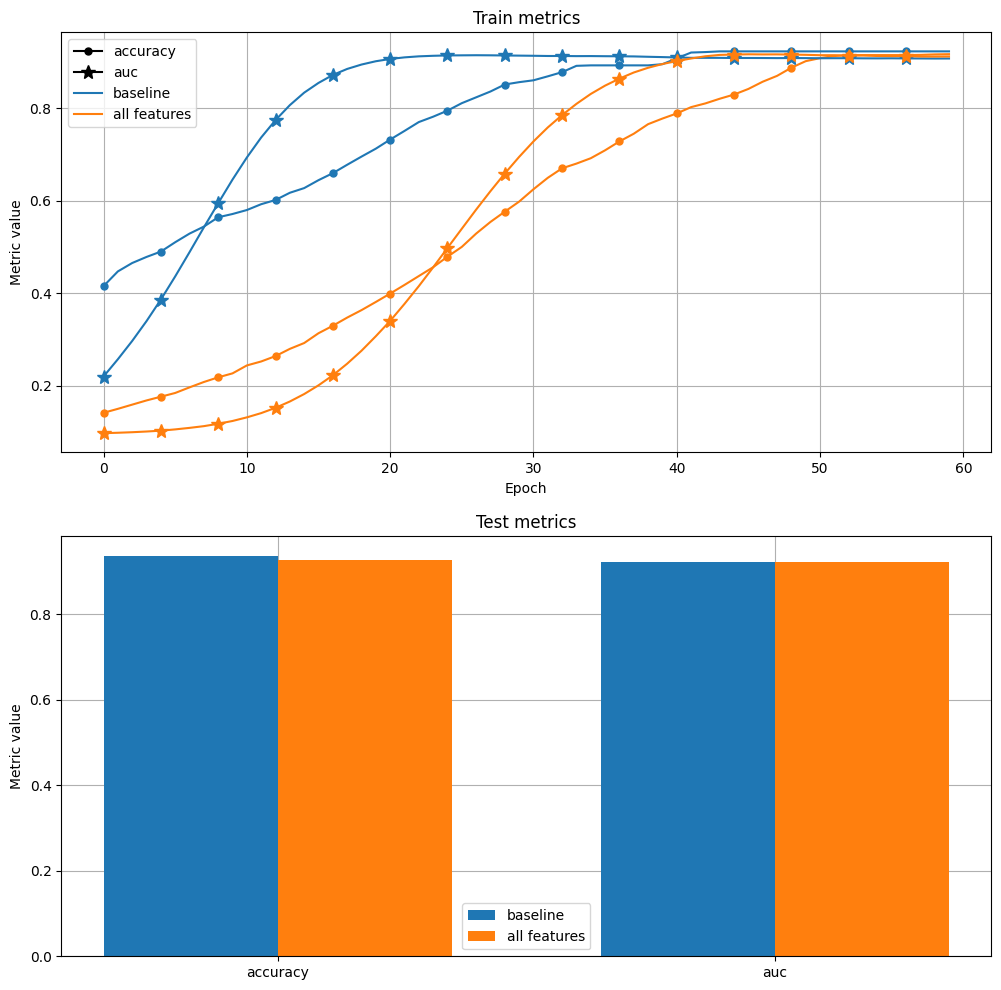

In [54]:
#comparing our two models
ml_edu.results.compare_experiment([experiment, experiment_all_features],
                                  ['accuracy', 'auc'],
                                  test_features, test_labels)